In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import scipy as sp

from shapely.geometry import Polygon

In [82]:
def fractal_dimension(Z, threshold=0):
    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

In [3]:
import rasterio as rio

landsat = rio.open("https://github.com/MUSA-550-Fall-2020/assignment-3/raw/master/data/landsat8_philly.tif")

In [4]:
city = gpd.read_file("https://raw.githubusercontent.com/MUSA-550-Fall-2020/assignment-3/master/data/City_Limits.geojson")
subs = city.envelope.difference(city)

city = city.to_crs('epsg:32618')
subs = subs.to_crs('epsg:32618')

In [5]:
from rasterio.mask import mask

urbmask, urbmask_transform = mask(
    dataset=landsat,
    shapes=city.geometry,
    crop=True,  # remove pixels not within boundary
    all_touched=True,  # get all pixels that touch the boudnary
    filled=False,  # do not fill cropped pixels with a default value
)

submask, surbmask_transform = mask(
    dataset=landsat,
    shapes=subs.geometry,
    crop=True,  # remove pixels not within boundary
    all_touched=True,  # get all pixels that touch the boudnary
    filled=False,  # do not fill cropped pixels with a default value
)

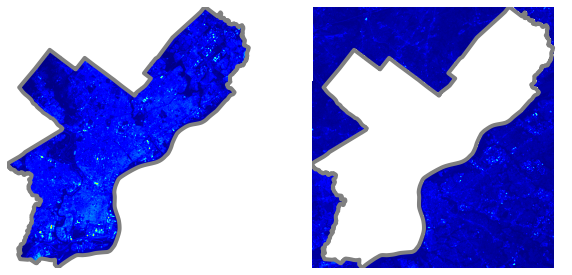

In [9]:
import matplotlib.pyplot as plt

landsat_extent = [
    landsat.bounds.left,
    landsat.bounds.right,
    landsat.bounds.bottom,
    landsat.bounds.top,
]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(urbmask[0], cmap="jet", extent=landsat_extent)

city.boundary.plot(ax=axs[0], color="gray", linewidth=4)

axs[1].imshow(submask[0], cmap="jet", extent=landsat_extent)

city.boundary.plot(ax=axs[1], color="gray", linewidth=4)

axs[0].set_axis_off()
axs[1].set_axis_off()

In [10]:
def ndvi(nir, red):

    nir = nir.astype(float)
    red = red.astype(float)
    
    check = np.logical_and( red.mask == False, nir.mask == False )
    
    ndvi = np.where(check,  (nir - red ) / ( nir + red ), np.nan )
    return ndvi 

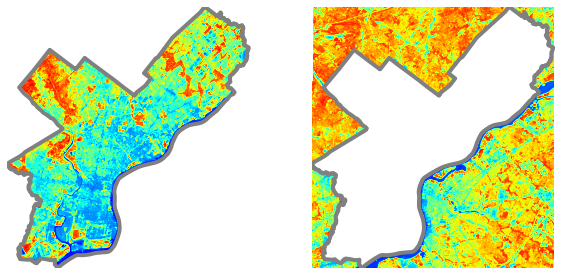

In [11]:
import numpy as np

red = urbmask[3]
nir = urbmask[4]

urb_veg = ndvi(nir, red)

red = submask[3]
nir = submask[4]

sub_veg = ndvi(nir, red)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(urb_veg, cmap="jet", extent=landsat_extent)

city.boundary.plot(ax=axs[0], color="gray", linewidth=4)

axs[1].imshow(sub_veg, cmap="jet", extent=landsat_extent)

city.boundary.plot(ax=axs[1], color="gray", linewidth=4)

axs[0].set_axis_off()
axs[1].set_axis_off()

In [23]:
Z = (urb_veg > 0.25)

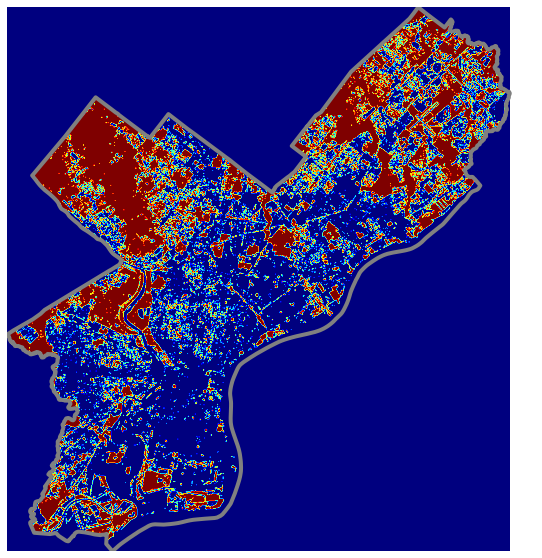

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(Z, cmap="jet", extent=landsat_extent)
city.boundary.plot(ax=ax, color="gray", linewidth=4)
ax.set_axis_off()

In [83]:
print("Minkowski–Bouligand dimension (computed): ", fractal_dimension(urb_veg, 0.25))

Minkowski–Bouligand dimension (computed):  1.7128153606200642


In [84]:
Z = (sub_veg > 0.25)

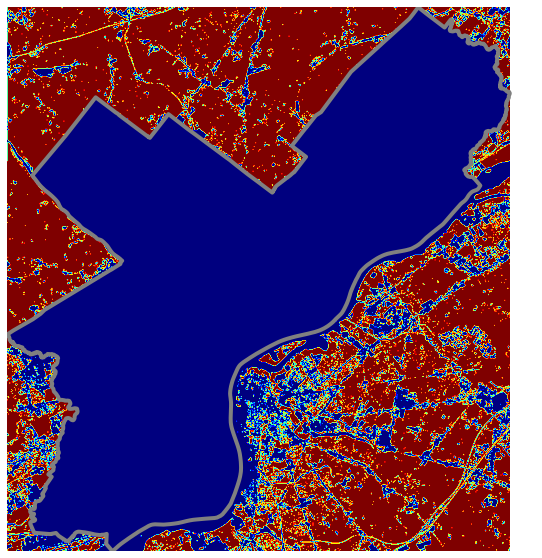

In [85]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(Z, cmap="jet", extent=landsat_extent)
city.boundary.plot(ax=ax, color="gray", linewidth=4)
ax.set_axis_off()

In [87]:
print("Minkowski–Bouligand dimension (computed): ", fractal_dimension(sub_veg, 0.25))

Minkowski–Bouligand dimension (computed):  1.6889512432740734


In [49]:
streets = gpd.read_file("http://data-phl.opendata.arcgis.com/datasets/c36d828494cd44b5bd8b038be696c839_0.geojson")
streets = streets.to_crs('epsg:32618')

In [56]:
streets['dissolve'] = 1
streets.head()

,OBJECTID,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,STCL2_,STCL2_ID,PRE_DIR,ST_NAME,...,CLASS,RESPONSIBL,UPDATE_,NEWSEGDATE,MULTI_REP,STREETLABE,STNAME,Shape__Length,geometry,dissolve
0,1,29150,29152,None,None,449.862854,None,None,,CALLOWHILL,...,3,FAM,1997-02-10T00:00:00,None,0.0,CALLOWHILL ST,CALLOWHILL ST,178.662082,"LINESTRING (486017.203 4423311.038, 485881.928...",1
1,2,29150,29148,None,None,540.082753,None,None,N,15TH,...,3,FAM,1997-02-10T00:00:00,None,0.0,N 15TH ST,N 15TH ST,215.300676,"LINESTRING (486017.203 4423311.038, 486032.146...",1
2,3,29152,29025,None,None,446.104381,None,None,,CALLOWHILL,...,3,FAM,1997-02-10T00:00:00,None,0.0,CALLOWHILL ST,CALLOWHILL ST,177.169755,"LINESTRING (485881.928 4423333.120, 485747.768...",1
3,4,29022,29021,None,None,447.261004,None,None,,CARLTON,...,5,CITY,1997-02-10T00:00:00,None,0.0,CARLTON ST,CARLTON ST,177.629772,"LINESTRING (485875.138 4423287.415, 485740.801...",1
4,5,29021,29025,None,None,148.216272,None,None,N,17TH,...,4,CITY,1997-06-27T00:00:00,None,0.0,N 17TH ST,N 17TH ST,59.085580,"LINESTRING (485740.801 4423310.300, 485747.768...",1


In [53]:
meta = landsat.meta.copy()
meta.update(compress='lzw')

In [70]:
with rio.open('./rasterized.tif', 'w+', **meta) as out:
    out_arr = out.read(1)

    shapes = ((geom, value) for geom, value in zip(streets.geometry, streets['dissolve'].astype('int64')))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

In [71]:
rasterized = rio.open('rasterized.tif')

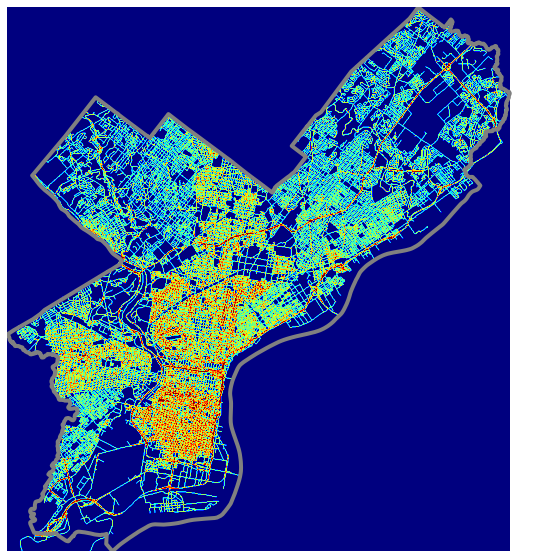

In [81]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(rasterized.read(1), cmap="jet", extent=landsat_extent)
city.boundary.plot(ax=ax, color="gray", linewidth=4)
ax.set_axis_off()

In [80]:
print("Minkowski–Bouligand dimension (computed): ", fractal_dimension(rasterized.read(1), 0.25))

Minkowski–Bouligand dimension (computed):  1.7341653438971791
